# [Lab] Text Classification: Emotions Detection

## Modules

In [ ]:
!pip install nlp

In [2]:
# Import NumPy for numerical operations
import numpy as np
# Import pandas for data manipulation and analysis
import pandas as pd

# Import nlp library for natural language processing tasks
import nlp

# Import TensorFlow library for machine learning tasks
import tensorflow as tf
# Import Tokenizer and pad_sequences from Keras for text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Import EarlyStopping callback from Keras for early stopping during model training
from tensorflow.keras.callbacks import EarlyStopping

# Import Matplotlib for creating visualizations
import matplotlib.pyplot as plt

## Data

In [21]:
# Load training, validation, and test datasets from CSV files
train_df = pd.read_csv("training.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

# Extract tweets and labels from the training dataset
train_tweets = train_df['text']
train_labels = train_df['label']

# Extract tweets and labels from the validation dataset
val_tweets = val_df['text']
val_labels = val_df['label']

# Extract tweets and labels from the test dataset
test_tweets = test_df['text']
test_labels = test_df['label']

In [22]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [23]:
train_tweets[0]

'i didnt feel humiliated'

In [24]:
# Mapping of numerical indices to corresponding emotion classes
index_to_class = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

## Tokenization

In [25]:
# Create a Tokenizer with a vocabulary size of 10,000 and an out-of-vocabulary token
tokenizer = Tokenizer(num_words=10000, oov_token='<UKN>')

# Fit the Tokenizer on the training tweets to build the vocabulary
tokenizer.fit_on_texts(train_tweets)

In [26]:
# Function to convert text data into padded sequences using a tokenizer
def get_sequences(tokenizer, tweets):
    # Convert text to sequences of integers using the tokenizer
    sequences = tokenizer.texts_to_sequences(tweets)

    # Pad sequences to a maximum length of 50, truncating or padding as needed
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=50)

    # Return the padded sequences
    return padded

In [27]:
# Obtain padded sequences for the training tweets using the tokenizer
padded_train = get_sequences(tokenizer, train_tweets)

# Obtain padded sequences for the validation tweets using the tokenizer
padded_val = get_sequences(tokenizer, val_tweets)

# Obtain padded sequences for the test tweets using the tokenizer
padded_test = get_sequences(tokenizer, test_tweets)

In [28]:
padded_train[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Training

In [29]:
# Create a sequential model
model = tf.keras.models.Sequential([
    # Embedding layer with a vocabulary size of 10,000, embedding dimension of 16, and input length of 50
    tf.keras.layers.Embedding(10000, 16, input_length=50),

    # Bidirectional LSTM layer with 20 units, returning sequences (for stacking another LSTM layer)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),

    # Bidirectional LSTM layer with 20 units (no return_sequences as it's the last LSTM layer)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),

    # Dense output layer with 6 units (for 6 emotion classes) and softmax activation
    tf.keras.layers.Dense(6, activation='softmax')
])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Compile the model using sparse categorical crossentropy as the loss function,
# Adam optimizer, and accuracy as the metric to monitor during training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [32]:
# EarlyStopping callback to stop training when the validation accuracy stops improving
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy for early stopping
    mode='min',              # 'min' mode means training will stop when the quantity monitored has stopped decreasing
    verbose=1,               # Verbosity level (1: update messages, 0: silent)
    patience=10               # Number of epochs with no improvement after which training will be stopped
)

In [33]:
# Convert padded sequences and labels for training data to NumPy arrays
padded_train = np.array(padded_train)
train_labels = np.array(train_labels)

# Convert padded sequences and labels for validation data to NumPy arrays
padded_val = np.array(padded_val)
val_labels = np.array(val_labels)

In [34]:
# Train the model on the padded training data and corresponding labels
# Validate on the padded validation data with validation labels
# Use the EarlyStopping callback to stop training if validation accuracy doesn't improve for 10 consecutive epochs
history = model.fit(
    padded_train,             # Padded training sequences
    train_labels,             # Training labels
    validation_data=(padded_val, val_labels),  # Validation data and labels
    epochs=10,                # Number of epochs
    callbacks=[early_stop]    # EarlyStopping callback
)

Epoch 1/10
500/500 [==============================] - 38s 56ms/step - loss: 1.3063 - accuracy: 0.4748 - val_loss: 0.7746 - val_accuracy: 0.7135
Epoch 2/10
500/500 [==============================] - 10s 21ms/step - loss: 0.5273 - accuracy: 0.8179 - val_loss: 0.5886 - val_accuracy: 0.8020
Epoch 3/10
500/500 [==============================] - 8s 17ms/step - loss: 0.3201 - accuracy: 0.8899 - val_loss: 0.5197 - val_accuracy: 0.8290
Epoch 4/10
500/500 [==============================] - 8s 16ms/step - loss: 0.2112 - accuracy: 0.9280 - val_loss: 0.4019 - val_accuracy: 0.8725
Epoch 5/10
500/500 [==============================] - 7s 14ms/step - loss: 0.1519 - accuracy: 0.9509 - val_loss: 0.4462 - val_accuracy: 0.8700
Epoch 6/10
500/500 [==============================] - 9s 18ms/step - loss: 0.1270 - accuracy: 0.9593 - val_loss: 0.3732 - val_accuracy: 0.8845
Epoch 7/10
500/500 [==============================] - 8s 15ms/step - loss: 0.1122 - accuracy: 0.9636 - val_loss: 0.3930 - val_accuracy: 0.88

## Evaluation

In [35]:
# Convert padded sequences and labels for test data to NumPy arrays
padded_test = np.array(padded_test)
test_labels = np.array(test_labels)

In [37]:
# Evaluate the trained model on the padded test data and corresponding labels
test_loss, test_accuracy = model.evaluate(padded_test, test_labels)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

63/63 [==============================] - 1s 12ms/step - loss: 0.4271 - accuracy: 0.8845
Test Accuracy: 88.45%


In [41]:
# Function to visualize training and validation history
def show_history(history):
    # Get the number of epochs trained
    epochs_trained = len(history.history['loss'])

    # Set up the figure with two subplots (Accuracy and Loss)
    plt.figure(figsize=(8, 4))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), history.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), history.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), history.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), history.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plot
    plt.show()

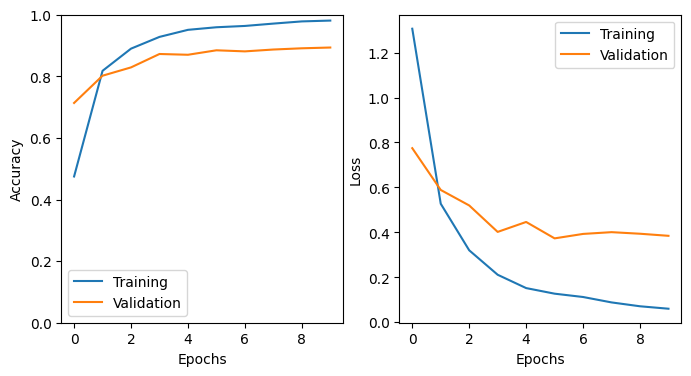

In [42]:
show_history(history)

In [43]:
test_tweets[146],index_to_class[test_labels[146]]

('i am feeling eager to start doing some work the man who works there literally says so uhm you guys want to go in back and see if we can find anything to do',
 'Joy')

In [44]:
preds = model.predict(np.expand_dims(padded_test[146],axis=0))[0]

1/1 [==============================] - 2s 2s/step


In [46]:
preds

array([3.9711016e-05, 9.9969459e-01, 2.3057760e-04, 2.6679389e-05,
       3.1506604e-06, 5.3548711e-06], dtype=float32)

In [45]:
index = np.argmax(preds)
print(index_to_class[index])

Joy
